## Disclaimer: 

Code, type hints and some comments were generated by ChatGPT

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional

# Layers

Layer is a unit in the network that transforms input data into some output -> kind of processing function inside of the network.

In [115]:
# Super class for NN layer, must have atlest forward passing and backward propagation
class Layer:
    # process input to output
    def forward(self, X: np.ndarray) -> np.ndarray:
        raise NotImplementedError
    # process gradient during backward prop
    def backward(self, grad: np.ndarray) -> np.ndarray:
        raise NotImplementedError
    # return learning parameters if any
    def params(self) -> List[Tuple[np.ndarray, np.ndarray]]:
        return []

Some of the layers have learnable parameters. These parameters are weights and biases and we need to return them to optimizer so it can update them.
Example of such layer is Dense. It is a fully connected layer meaning that every node of the previous layer is connected to every node of current layer. Forward pass in this case simply multiplies X by weights and adds biases. Backward pass is way more complicated especiailly if you are trying to solve it without matrix multiplaction as we can see in second nn_math_class_example notebook. What it does is computes gradients for weights and biases, propagates them backward to the previous layer and lets the optimizer to upate weights and biases using gradient descent.

Good analogy from ChatGPT:

- Forward pass: “compute the output from input and current weights.”

- Backward pass: “tell each weight and bias how it should change to reduce the loss, and pass the rest of the error backward.”

About matrices in backward propagation:
Without the matrices it is surprisingly hard and time co nsuming to do. Especially if you don't have a fixed amount of layers and nodes and want it to be more or less flexible. But using matrices simplifies the code a lot:

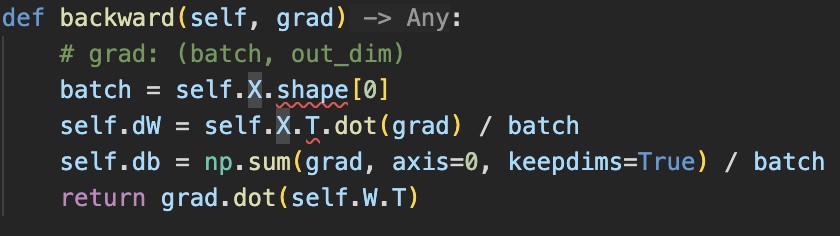




So, the backpropagation is the heart of learning in neural networks. But how it works in our example?

1. We calculate the gradient of the loss function. Great intuitive exaplantaion of what gradient is: https://www.youtube.com/watch?v=H1DJjyDFalw. If we imagine that our data is in 3D, gradient would the 2D vector that points direction to the highest point of our surface. However, in this case we are calculating gradient of loss function (which we want to minimize) and as I understand we are using negative gradient which points us the direction to the lowest loss function value. In this example Stochastic Gradient Descent is used meaning that we are using only random part of the data at time. SGD: https://www.youtube.com/watch?v=UmathvAKj802
2. We store the number of samples in the batch in order to average the gradients so that learning rate doesn't depend on batch size
3. Then we compute dW which is gradient of the weights W. We take the transpose matrix of our inputs X and perform dot multiplication with grad (gradient of the current layer output) and divide by batch number to get average value. All this tells each node in the layer how they should change own weight
4. We perform same for biases, but in this case we use sum function as biases are additive
5. Then we return a gradient of the loss with respect to the inputs of the layer. Since we are going backwards, this is passed to previous layer and used as "grad" variable or the gradient of output. Previous layer output <- Current layer input

What are weight initialization methods?
If we set all initial weights to zero it will cause symmetry - every neuron will learn the same thing. But if use completly random weights, it might cause vanishing or exploding gradients. So they designed different methods for different activation function. In this example we have Xavier initialization and He.

![Screenshot 2025-10-01 at 15.41.39.png](<attachment:Screenshot 2025-10-01 at 15.41.39.png>)


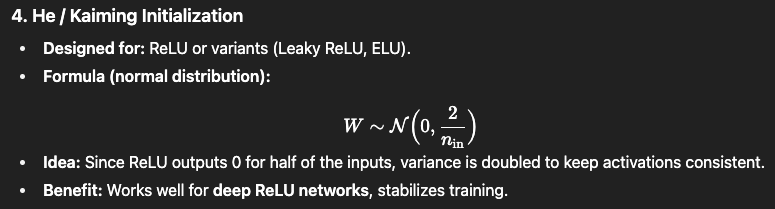
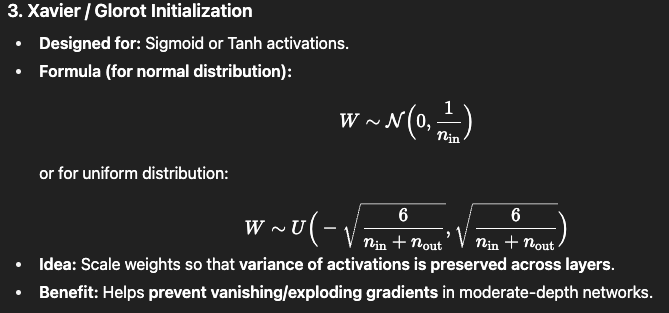

In [116]:
class Dense(Layer):
    def __init__(self, in_dim: int, out_dim: int, weight_init: str = "he") -> None:
        """
        Fully connected (dense) layer.
        
        Args:
            in_dim (int): Number of input features per sample.
            out_dim (int): Number of output features per sample.
            weight_init (str): Weight initialization method. Options: "he", "xavier", "normal".
        """
        self.in_dim: int = in_dim
        self.out_dim: int = out_dim

        # Initialize weights based on the chosen method
        if weight_init == "he":
            # He initialization for ReLU activations
            self.W: np.ndarray = np.random.randn(in_dim, out_dim) * np.sqrt(2.0 / in_dim)
        elif weight_init == "xavier":
            # Xavier/Glorot initialization for tanh/sigmoid activations
            self.W: np.ndarray = np.random.randn(in_dim, out_dim) * np.sqrt(1.0 / in_dim)
        else:
            # Standard normal small initialization
            self.W: np.ndarray = np.random.randn(in_dim, out_dim) * 0.01

        # Initialize biases to zeros
        self.b: np.ndarray = np.zeros((1, out_dim))

        # Gradients placeholders (same shape as parameters)
        self.dW: np.ndarray = np.zeros_like(self.W)
        self.db: np.ndarray = np.zeros_like(self.b)

        # Cache input for backward pass
        self.X: np.ndarray | None = None

    def forward(self, X: np.ndarray) -> np.ndarray:
        """
        Forward pass of the dense layer.
        
        Args:
            X (np.ndarray): Input data of shape (batch_size, in_dim)
        
        Returns:
            np.ndarray: Output of shape (batch_size, out_dim)
        """
        # Cache input for backward pass
        self.X = X
        # Linear transformation
        return X.dot(self.W) + self.b

    def backward(self, grad: np.ndarray) -> np.ndarray:
        """
        Backward pass of the dense layer. Computes gradients w.r.t. weights, biases, and inputs.
        
        Args:
            grad (np.ndarray): Gradient of the loss w.r.t. layer output, shape (batch_size, out_dim)
        
        Returns:
            np.ndarray: Gradient of the loss w.r.t. layer input, shape (batch_size, in_dim)
        """
        batch: int = self.X.shape[0]

        # Gradient w.r.t. weights
        self.dW = self.X.T.dot(grad) / batch
        # Gradient w.r.t. biases
        self.db = np.sum(grad, axis=0, keepdims=True) / batch
        # Gradient w.r.t. inputs (to propagate to previous layer)
        return grad.dot(self.W.T)

    def params(self) -> List[Tuple[np.ndarray, np.ndarray]]:
        """
        Returns the parameters and their corresponding gradients.
        
        Returns:
            List of tuples: [(weights, weight_grad), (biases, bias_grad)]
        """
        return [(self.W, self.dW), (self.b, self.db)]


Then there are some layers that doesn't return any learnable parameters. They just process the input data to the output. For example ReLu:

In [117]:
class ReLU(Layer):
    def __init__(self):
        self.mask = None
    def forward(self, X):
        self.mask = (X > 0)
        return X * self.mask
    def backward(self, grad):
        return grad * self.mask

ReLu's forward pass keeps only positive values - self.mask is a boolean array, where positive values are masked as True and negative as False. When we multiply the data by it's mask, under the hood booleana are just integers 1 and 0. So the negative values are multiplied by 0 and become zero, while positive don't change at all. 

In the backward pass, for all neurons where data is positive, we let the gradient flow, and for negative data we "block" the neuron by zeroing the gradient.

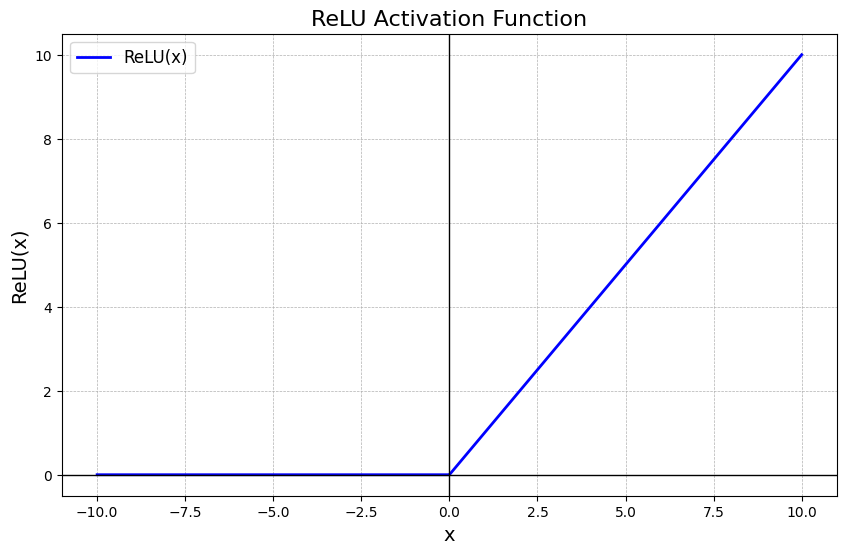

Sigmoid layer is another classic activation function

In [118]:
class Sigmoid(Layer):
    def __init__(self):
        self.out = None
    def forward(self, X):
        self.out = 1 / (1 + np.exp(-X))
        return self.out
    def backward(self, grad):
        return grad * (self.out * (1 - self.out))

Sigmoid function "squeezes" values between 0 and 1, where:

Small or negative inputs → outputs close to 0.

Large positive inputs → outputs close to 1.

Values around 0 get mapped near 0.5.


By that squeezing, we make the network nonlinear and this behaviour is useful for things like probabilities in binary classification. As the output could be interpreted as a probability (e.g. 0.8 = 80% chance of being positive class), sigmoid is commonly used as a final layer in the network.


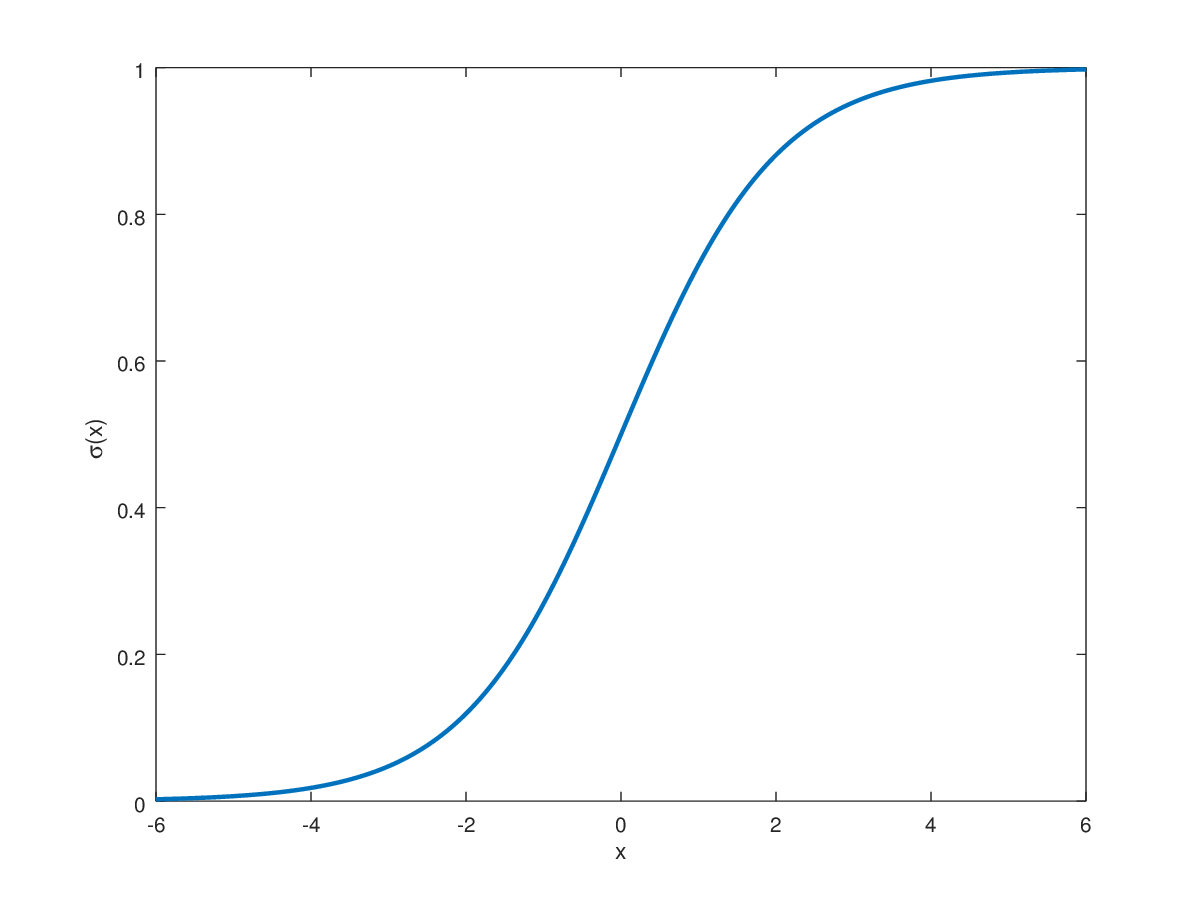

In [119]:
class Tanh(Layer):
    def __init__(self):
        self.out = None
    def forward(self, X):
        self.out = np.tanh(X)
        return self.out
    def backward(self, grad):
        return grad * (1 - self.out ** 2)

Tanh function is a relative to sigmoid, but with few differences. It maps the value into the range from -1 to 1, where:

Negative inputs → outputs close to -1

Positive inputs → outputs close to +1

Input 0 → output 0


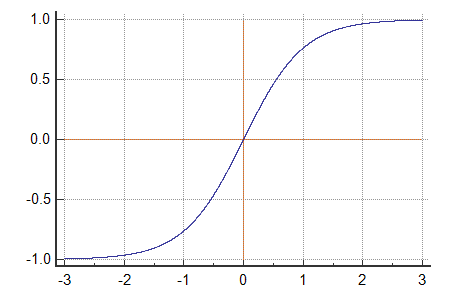

In this case, tanh function output cannot be interpreted as probability anymore. So, it's not usually used as the final output. Instead, it's sometimes used in hidden layers of RNNs or LSTMs because being zero-centered and symmetric helps optimization. But in common, ReLu is often preferred due to faster training.

Softamax layer is a usual choice for multi-class classification problems:

In [120]:
class Softmax(Layer):
    # Note: combined with cross-entropy loss gives a simpler gradient.
    def __init__(self):
        self.out = None
    def forward(self, X):
        X = X - np.max(X, axis=1, keepdims=True)
        exp = np.exp(X)
        self.out = exp / np.sum(exp, axis=1, keepdims=True)
        return self.out
    def backward(self, grad):
        # grad is (batch, classes) coming from loss
        # For numeric stability, assume grad already computed correctly
        # If using cross-entropy + softmax, one should call loss.grad that takes them into account
        return grad

It converts raw scores (called also logits) into probabilities:

The biggest logit gets the biggest probability.

The outputs are always between (0,1).

Probabilities sum to 1 → interpretable as categorical probabilities.

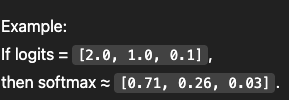
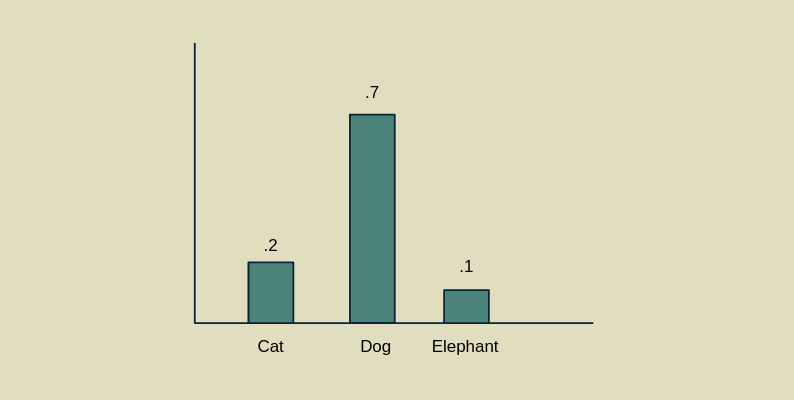

# Losses

Loss functions general purpose is to tell how wrong is the prediction. It measures difference between real value and estimated, therefore if prediction is far from real value -> high loss. In other words it also can be called the signal that tells the models how to improve.

Loss function is highly connected with gradient, as loss function generates the gradient and gradient is the core of learning:
1. Compute loss function
2. Compute the gradient of the loss -> tells the direction and magnitude to adjust each weight to reduce the loss
3. Update the weights

So, in our case, every loss function must do calculation of the error (self.__call__) and gradient with respect to predictions (self.grad):

In [121]:
class Loss:
    def __call__(self, y_pred, y_true):
        raise NotImplementedError
    def grad(self, y_pred, y_true):
        raise NotImplementedError

There are different loss function and choice of which one to use is closely related with the activation function in the output layer (nature of the problem one tries to solve)

MSE or Mean Squared Error is commonly used fot regression tasks. It measures the average square difference between predictions and true values. Mathematically it:
1. Counts the difference between real and predicted value
2. Squares it. Main purpose of using square is to enforce bigger punishment for bigger errors and smaller for smaller. If you your real value is 10 and model predicts 1000 you want it to react faster and change weights more aggresivly than if prediction is 15. Also squaring simplifies some math.
3. Multiply by 0.5. This is optional as it doesn't change the general outcome but is convinient for gradient computation (again simplifies some maths under the hood)
4. Take the average of the result. As we process everything in batches, we need to take average over all samples in the batch

And after that, to compute gradient we simply take the difference and divide by number of samples. If prediction is greater than true value, gradient is positive and we need to decrease prediction and vice versa

MSE is used for regression problems and works well with Linear Output, so we don't need to use any special output layer.

In [122]:
class MSE(Loss):
    def __call__(self, y_pred, y_true):
        return np.mean(0.5 * (y_pred - y_true) ** 2)
    def grad(self, y_pred, y_true):
        batch = y_true.shape[0]
        return (y_pred - y_true) / batch

Cross entropy, in turn, is a Loss function for different kind of problems - classification. It measures the difference between two probability distributions. Intuitevely it could be undestand as if the model assigns high probability to the correct class then the loss is small.

In [123]:
class CrossEntropy(Loss):
    def __call__(self, y_pred, y_true):
        # y_pred: probabilities (after softmax)
        # y_true: either one-hot or integer labels
        eps = 1e-12
        
        # Assign predicted probability to the correct class
        if y_true.ndim == 1 or (y_true.ndim == 2 and y_true.shape[1] == 1):
            # integer labels
            y_true = y_true.reshape(-1)
            probs = np.clip(y_pred[range(len(y_pred)), y_true], eps, 1.0)
            return -np.mean(np.log(probs))
        else:
            # one-hot
            probs = np.clip(y_pred, eps, 1.0)
            return -np.mean(np.sum(y_true * np.log(probs), axis=1))
        
    def grad(self, y_pred, y_true):
        batch = y_pred.shape[0]
        # If y_true are integer labels, convert to one-hot
        if y_true.ndim == 1 or (y_true.ndim == 2 and y_true.shape[1] == 1):
            y_true = y_true.reshape(-1)
            grad = y_pred.copy()
            grad[range(batch), y_true] -= 1
            return grad / batch
        else:
            return (y_pred - y_true) / batch

Cross entropy works greatly with softmax function and usually softmax + cross entropy is preferred pair. If softmax is applied before cross entropy loss function, then math of back propagation becomes much simplier.

Why would we need two loss function for different problems? It is technically possible to use MSE for classification, but the porblem with that is MSE treat model output as real number which means that gradients can become very small when probabilities are between 0 and 1. This would take forever to train. Cross Entropy in turn gives you stronger gradients.

# Optimizer

Now, we have a loss function that computes how wrong model is and the gradient that tells us which direction to move. Next thing what we need is decide how much to move. This is a task for optimizer. In simple words, the optimizer updates the model's parameters to minimize the loss.

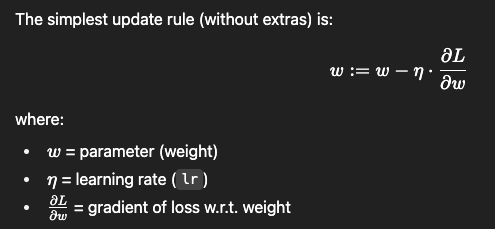

In [124]:
class SGD:
    def __init__(self, lr=0.01, momentum=0.0, l2=0.0):
        self.lr = lr
        self.momentum = momentum
        self.l2 = l2
        # velocity per parameter (list of arrays matching params)
        self.velocity = None


    def step(self, params):
    # params: list of tuples (param_array, grad_array)
        if self.velocity is None:
            self.velocity = [np.zeros_like(p[0]) for p in params]
        for i, (p, g) in enumerate(params):
            # add L2 regularization to gradient (weight decay)
            if self.l2 != 0 and p.ndim != 1: # skip biases
                g = g + self.l2 * p
            v = self.velocity[i]
            v[...] = self.momentum * v - self.lr * g
            p += v


    def set_lr(self, new_lr):
        self.lr = new_lr

Optimizer has few parameters:
- lr or learning rate - controls how big each step is. learning rate adjustement allows to dynamically change learning rate, for instance decay it over epochs
- momentum controls how much of the previous step's direction you keep. Instead of only reacting to the current gradient, it also keeps a “memory” of previous updates → smoother, faster convergence and less oscillation.
- l2 is regularization parameter and control strength of weight decay. Weight decay penalizes large weights and encourages simpler models which helps prevent overfitting
- velocity is memory of past gradients for momentum. It stores last update direction

Intuitive analogy from ChatGPT

Imagine a ball rolling down a hill:

- The **loss** surface is the hill.
- The **gradient** points downhill.
- The **learning rate** is how big a step the ball takes each time.
- The **momentum** is the ball’s inertia — it keeps rolling even if the slope flattens temporarily.
- **L2 regularization** adds friction, so the ball doesn’t pick up too much speed and overshoot.

# Neural Network

In [125]:
class NeuralNetwork:

    # Initializes variables
    def __init__(self):
        self.layers = []
        self.loss = None
        self.optimizer = None
        self.history = {"loss": [], "lr": []}

    # Adds new layer to list of layers
    def add(self, layer):
        self.layers.append(layer)

    # Set loss function
    def set_loss(self, loss):
        self.loss = loss

    # Set optimizer
    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

    # Pass forward layer by layer
    # First iteration starts with passing original X, then output of the layer to next layer
    # X -> output -> output -> output
    def forward(self, X):
        out = X
        for layer in self.layers:
            out = layer.forward(out)
        return out
    

    # Pass backwards in the reversed list
    # First iteration with loss gradient, then the "rest" of error
    def backward(self, loss_grad):
        grad = loss_grad
        # Propagate through layers in reverse
        for layer in reversed(self.layers):
            grad = layer.backward(grad)


    def params(self):
        # flatten all param tuples
        params = []
        for layer in self.layers:
            params.extend(layer.params())
        return params
    
    # Make a prediction
    def predict(self, X):
        out = self.forward(X)
        # if last layer is Softmax, return class indices
        if isinstance(self.layers[-1], Softmax):
            return np.argmax(out, axis=1)
        return out
    
    # Compare prediction with real value
    def evaluate(self, X, y):
        y_pred = self.forward(X)
        loss_val = self.loss(y_pred, y)
        return loss_val
    
    def fit(self, X, y, epochs=10, batch_size=32, verbose=True, lr_schedule=None):
        # Total amount of samples
        n_samples = X.shape[0]
        # Start epochs:
        for epoch in range(1, epochs + 1):
            # Learning rate schedule must be a function
            # Dynamically updates learning rate if function provided
            if lr_schedule is not None:
                new_lr = lr_schedule(epoch)
                self.optimizer.set_lr(new_lr)
        # Shuffle
            perm = np.random.permutation(n_samples)
            X_sh = X[perm]
            y_sh = y[perm]
            # Store loss of epoch
            epoch_loss = 0.0
            # For all samples with the step of batch size:
            for i in range(0, n_samples, batch_size):
                # Fetch a batch
                xb = X_sh[i:i+batch_size]
                yb = y_sh[i:i+batch_size]
                # Pass forward through network
                out = self.forward(xb)
                # Compute Loss value for batch
                loss_val = self.loss(out, yb)
                # Multiply by batch size to later compute mean epoch loss.
                epoch_loss += loss_val * xb.shape[0]
                # Gradient of loss wrt predictions
                grad = self.loss.grad(out, yb)
                # Pass backwards
                self.backward(grad)
                # Update params
                self.optimizer.step(self.params())
                # Compute mean epoch loss
            epoch_loss /= n_samples
            # Append loss and learning rate to history so it can be plotted next
            self.history["loss"].append(epoch_loss)
            self.history["lr"].append(self.optimizer.lr)
            if verbose:
                print(f"Epoch {epoch}/{epochs} - loss: {epoch_loss:.6f} - lr: {self.optimizer.lr:.6f}")

    def plot_learning_rate_and_loss(self):
        plt.plot(self.history["loss"])
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Loss")
        plt.show()

        plt.plot(self.history["lr"])
        plt.xlabel("Epoch")
        plt.ylabel("Learning Rate")
        plt.title("Learning Rate")
        plt.show()

The main pipeline happens in fit() function. Shortly what it does:
1. Shuffle the data
2. Split the data into batches
3. Pass the data forward through network
4. Compute the loss
5. Backpropage gradients
6. Updates parameters
7. Logs process and optionally adjusts learning rate 

# Examples

## Regression

In [126]:
from sklearn.datasets import make_regression
# Generate synthetic regression data
X, y = make_regression(
    n_samples=200,    # number of samples
    n_features=5,     # number of input features
    noise=10.0,       # add some randomness
    random_state=42
)
y = y.reshape(-1, 1)  # shape (200,1)


Epoch 1/1000 - loss: 4701.457181 - lr: 0.000495
Epoch 2/1000 - loss: 4684.787874 - lr: 0.000490
Epoch 3/1000 - loss: 4652.236179 - lr: 0.000485
Epoch 4/1000 - loss: 4618.233292 - lr: 0.000480
Epoch 5/1000 - loss: 4586.473664 - lr: 0.000475
Epoch 6/1000 - loss: 4554.813485 - lr: 0.000471
Epoch 7/1000 - loss: 4517.923201 - lr: 0.000466
Epoch 8/1000 - loss: 4467.994781 - lr: 0.000461
Epoch 9/1000 - loss: 4417.529595 - lr: 0.000457
Epoch 10/1000 - loss: 4349.824773 - lr: 0.000452
Epoch 11/1000 - loss: 4233.087053 - lr: 0.000448
Epoch 12/1000 - loss: 4049.329910 - lr: 0.000443
Epoch 13/1000 - loss: 3771.887020 - lr: 0.000439
Epoch 14/1000 - loss: 3408.765328 - lr: 0.000434
Epoch 15/1000 - loss: 2900.467769 - lr: 0.000430
Epoch 16/1000 - loss: 2462.835654 - lr: 0.000426
Epoch 17/1000 - loss: 2223.866177 - lr: 0.000421
Epoch 18/1000 - loss: 2043.274057 - lr: 0.000417
Epoch 19/1000 - loss: 1833.651167 - lr: 0.000413
Epoch 20/1000 - loss: 1558.290477 - lr: 0.000409
Epoch 21/1000 - loss: 1224.71

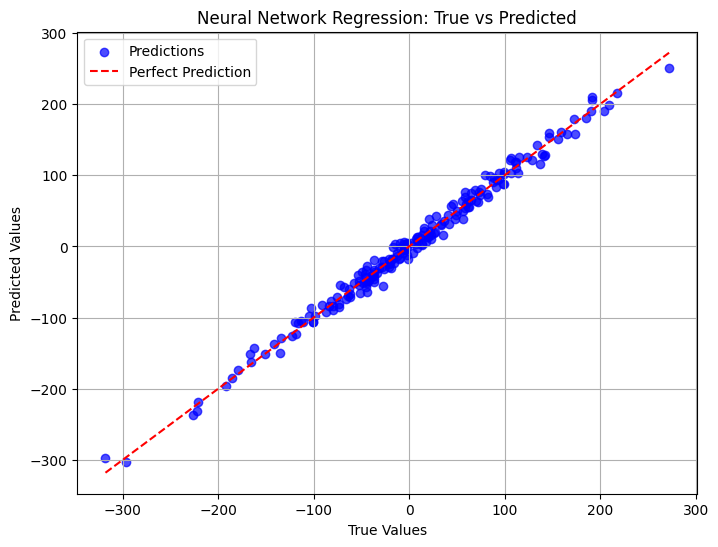

In [127]:
learning_rate = 0.0005

nn = NeuralNetwork()
# Input layer
nn.add(Dense(X.shape[1], 8))
nn.add(ReLU())
# Hidden layer
nn.add(Dense(8, 4))
nn.add(ReLU())
# Output
nn.add(Dense(4, 1))


nn.set_loss(MSE())
nn.set_optimizer(SGD(lr=learning_rate, momentum=0.9, l2=0.0001))


nn.fit(X, y, epochs=1000, batch_size=32, verbose=True, lr_schedule=lambda e: learning_rate * (0.99 ** e))


preds = nn.predict(X)

# Plot true vs predicted values
plt.figure(figsize=(8,6))
plt.scatter(y, preds, color='blue', alpha=0.7, label="Predictions")
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', label="Perfect Prediction")  # perfect prediction line
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Neural Network Regression: True vs Predicted")
plt.grid(True)
plt.legend()
plt.show()

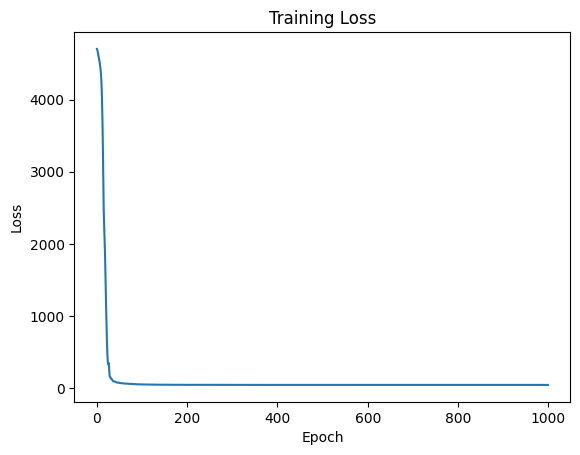

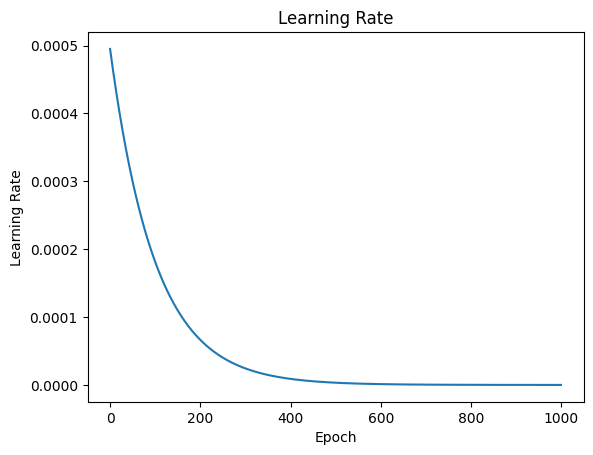

In [128]:
nn.plot_learning_rate_and_loss()

## Classification

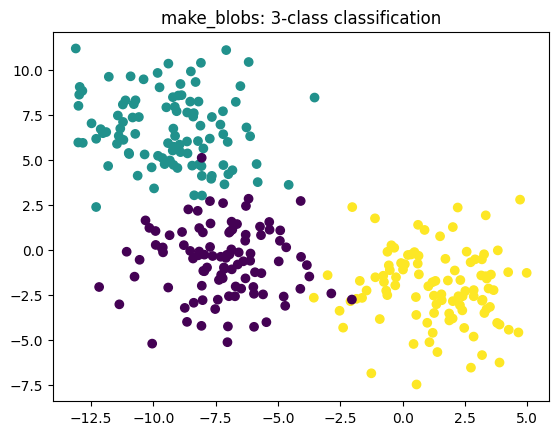

In [136]:
from sklearn.datasets import make_blobs

X, y = make_blobs(
    n_samples=300,
    centers=3,
    n_features=2,
    cluster_std=2
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.title("make_blobs: 3-class classification")
plt.show()

In [137]:
learning_rate = 0.00005

nn = NeuralNetwork()

# Input
nn.add(Dense(X.shape[1], 8))
nn.add(ReLU())

# Hidden: 8 → 6 neurons
nn.add(Dense(8, 6))
nn.add(ReLU())

# Output: 6 → 3 neurons (3 classes)
nn.add(Dense(6, len(set(y))))
nn.add(Softmax())

# Loss and optimizer
nn.set_loss(CrossEntropy())
nn.set_optimizer(SGD(lr=learning_rate, momentum=0.9))

nn.fit(
    X, y,
    epochs=200,
    batch_size=32,
    verbose=True,
    lr_schedule=lambda e: 0.1 * (0.99 ** e)  # optional decay
)
# Predicted class labels
y_pred = nn.predict(X)

# Accuracy
accuracy = np.mean(y_pred == y)
print(f"Training accuracy: {accuracy*100:.2f}%")


Epoch 1/200 - loss: 1.460181 - lr: 0.099000
Epoch 2/200 - loss: 0.609635 - lr: 0.098010
Epoch 3/200 - loss: 0.547755 - lr: 0.097030
Epoch 4/200 - loss: 0.408237 - lr: 0.096060
Epoch 5/200 - loss: 0.314204 - lr: 0.095099
Epoch 6/200 - loss: 0.262697 - lr: 0.094148
Epoch 7/200 - loss: 0.247714 - lr: 0.093207
Epoch 8/200 - loss: 0.215830 - lr: 0.092274
Epoch 9/200 - loss: 0.209660 - lr: 0.091352
Epoch 10/200 - loss: 0.210301 - lr: 0.090438
Epoch 11/200 - loss: 0.174452 - lr: 0.089534
Epoch 12/200 - loss: 0.247304 - lr: 0.088638
Epoch 13/200 - loss: 0.178128 - lr: 0.087752
Epoch 14/200 - loss: 0.167620 - lr: 0.086875
Epoch 15/200 - loss: 0.375191 - lr: 0.086006
Epoch 16/200 - loss: 0.180268 - lr: 0.085146
Epoch 17/200 - loss: 0.169799 - lr: 0.084294
Epoch 18/200 - loss: 0.234985 - lr: 0.083451
Epoch 19/200 - loss: 0.168126 - lr: 0.082617
Epoch 20/200 - loss: 0.150782 - lr: 0.081791
Epoch 21/200 - loss: 0.154365 - lr: 0.080973
Epoch 22/200 - loss: 0.545204 - lr: 0.080163
Epoch 23/200 - loss

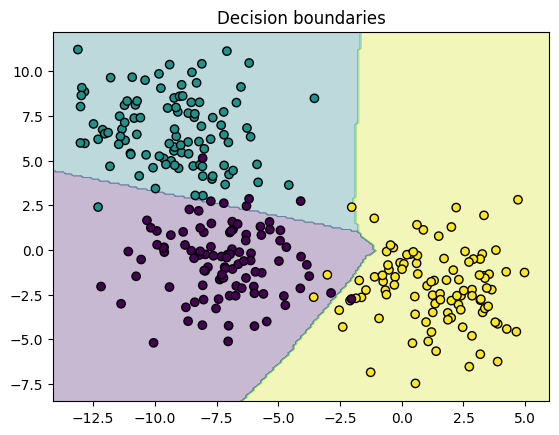

In [138]:
# Create a grid for plotting
xx, yy = np.meshgrid(np.linspace(X[:,0].min()-1, X[:,0].max()+1, 200),
                     np.linspace(X[:,1].min()-1, X[:,1].max()+1, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = nn.predict(grid).reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
plt.scatter(X[:,0], X[:,1], c=y, edgecolor='k', cmap='viridis')
plt.title("Decision boundaries")
plt.show()


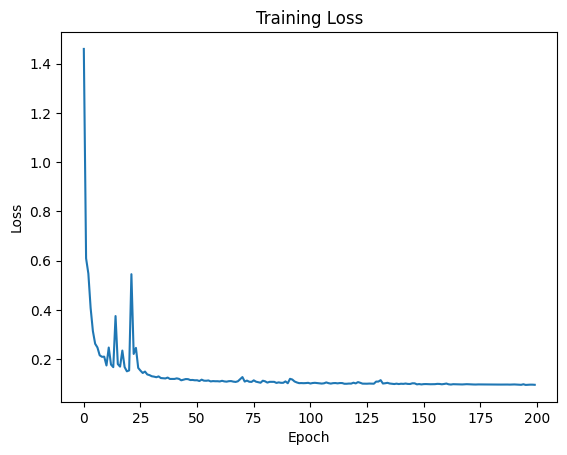

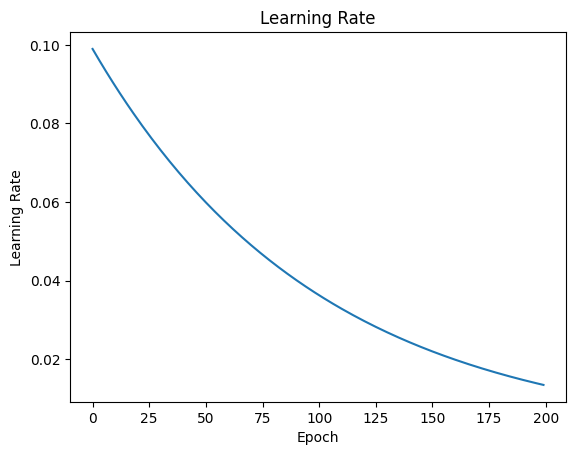

In [139]:
nn.plot_learning_rate_and_loss()